# Анализ данных Criteo: NWOE и NIV для оценки ATE

## Описание датасета

Датасет содержит данные A/B-тестов рекламной платформы Criteo для задач uplift modeling. Данные включают информацию о пользователях, их характеристиках и результатах воздействия рекламных кампаний.

[Criteo](http://ailab.criteo.com/criteo-uplift-prediction-dataset/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from statsmodels.stats.weightstats import ttest_ind
from pylift.eval import UpliftEval
import loymax as lm
from typing import Dict, Tuple, List
import warnings
warnings.filterwarnings('ignore')

# локальный файл
import loymax as lm

In [2]:
df = pd.read_csv('criteo-uplift-v2.1.csv')

In [3]:
display(df.sample(5))

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
6863827,12.616365,10.059654,8.894216,4.679882,10.280525,4.115453,0.294443,4.833815,3.934656,13.190056,5.300375,-0.168679,1,0,0,0
12353544,24.828627,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
12165820,14.753284,10.059654,8.214383,0.719526,10.280525,4.115453,-7.822229,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
3307145,23.662408,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
3604042,24.639841,10.059654,8.214383,4.679882,10.280525,4.115453,-8.493011,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0



### Структура данных
#### Столбцы с признаками пользователей:
- **f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11** - анонимизированные признаки пользователей

#### Ключевые столбцы для анализа:
- **treatment** - индикатор воздействия
  - 0 = контрольная группа (не получали рекламное воздействие)
  - 1 = тестовая группа (получали рекламное воздействие)

- **conversion** - целевая переменная (конверсия)
  - 0 = конверсия не произошла
  - 1 = конверсия произошла (пользователь совершил целевое действие)

- **visit** - посещение сайта
  - 0 = пользователь не посетил сайт
  - 1 = пользователь посетил сайт

- **exposure** - факт показа рекламы

## Цель анализа: Оценка ATE

**ATE (Average Treatment Effect)** - средний эффект воздействия, который показывает разность между средними значениями конверсии в тестовой и контрольной группах.

#### 1. NWOE (Net Weight of Evidence)
Метрика для оценки силы связи между признаком и uplift-эффектом

#### 2. NIV (Net Information Value)
Метрика для измерения предсказательной силы признака для uplift

## Предварительная работа с данными

In [4]:
results, df = lm.basic_eda_analysis(df, remove_duplicates=True, verbose=True)

=== РАЗМЕР ДАННЫХ ===
Строки: 13,979,592
Столбцы: 16

Использование памяти: 1706.49 MB (1,789,387,904 bytes)

=== ДУБЛИКАТЫ ===
Количество дубликатов: 1,259,545
Процент дубликатов: 9.01%
Дубликаты удалены. Новый размер: 12,720,047 строк

=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===
Общее количество пропущенных значений: 0
Общий процент пропущенных значений: 0.00%
Пропущенных значений не найдено

=== ТИПЫ ДАННЫХ ===
Распределение типов данных:
  float64: 12 столбцов
  int64: 4 столбцов

Числовые столбцы (16): ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'treatment', 'conversion', 'visit', 'exposure']
Категориальные столбцы (0): []



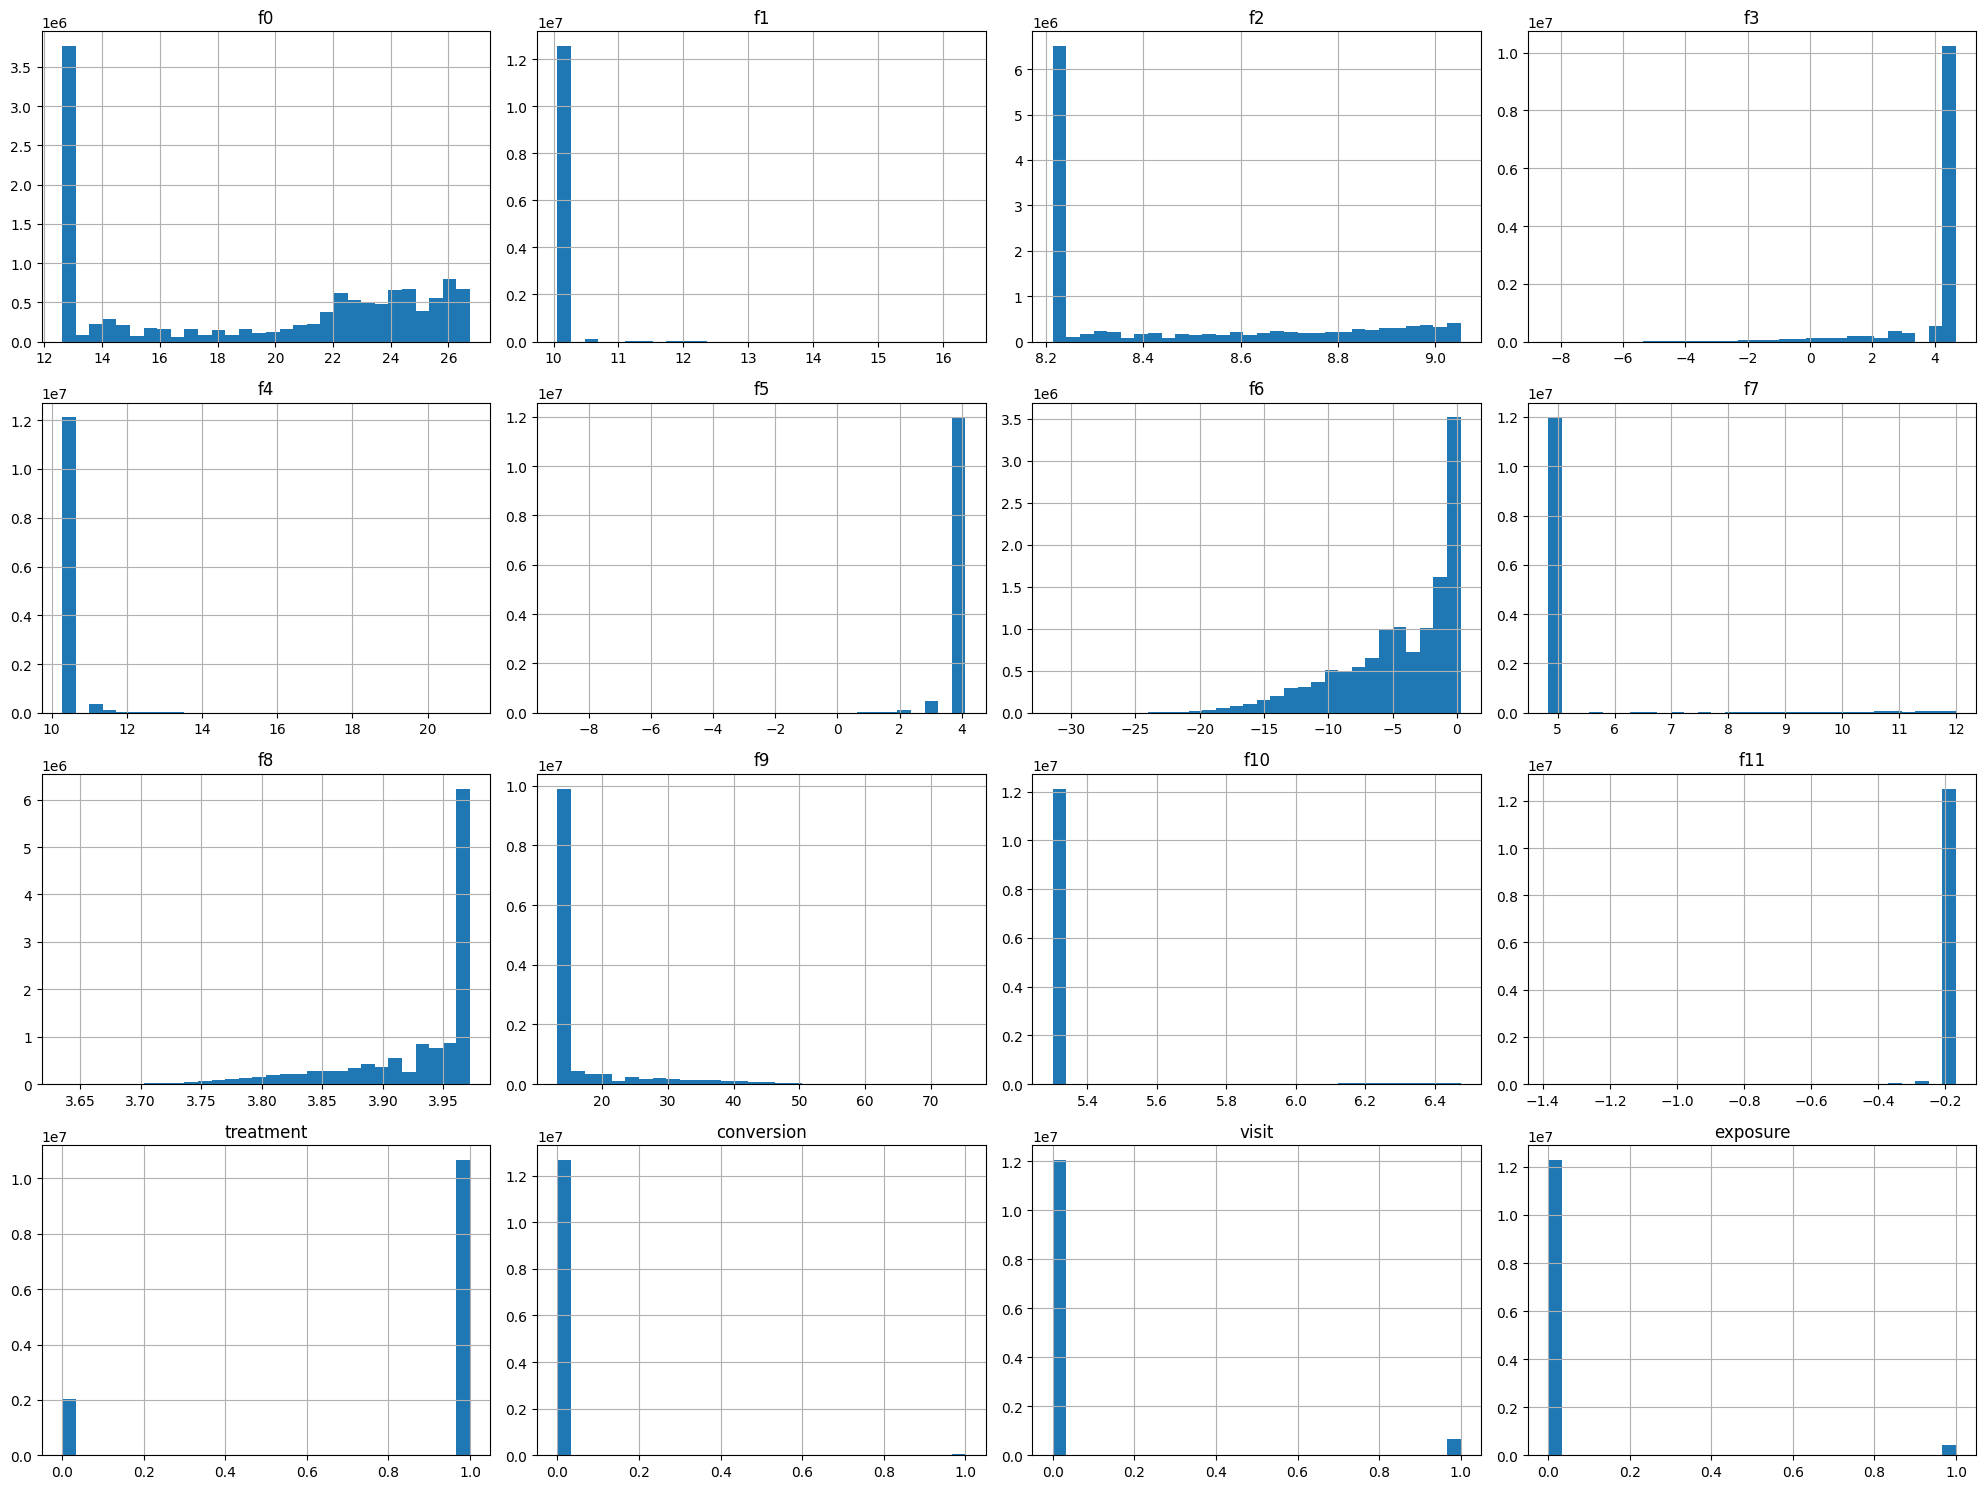

In [5]:
df.hist(figsize=(20, 15), bins=30)
plt.tight_layout()
plt.show()

## Анализ выбросов в данных

In [6]:
if __name__ == "__main__":
    analyzer = lm.OutlierAnalyzer(df)
    report = analyzer.generate_report()
    print(report)

Количественный анализ по колонкам:
- f0 : 0 выбросов (0.00%)
- f1 : 171938 выбросов (1.35%)
- f2 : 0 выбросов (0.00%)
- f3 : 2490224 выбросов (19.58%)
- f4 : 602016 выбросов (4.73%)
- f5 : 741209 выбросов (5.83%)
- f6 : 92082 выбросов (0.72%)
- f7 : 741209 выбросов (5.83%)
- f8 : 593066 выбросов (4.66%)
- f9 : 2815330 выбросов (22.13%)
- f10 : 602016 выбросов (4.73%)
- f11 : 201738 выбросов (1.59%)
- conversion : 40774 выбросов (0.32%)
- visit : 656908 выбросов (5.16%)
- exposure : 427919 выбросов (3.36%)

Общее кол-во выбросов: 10176429
* % от общего объема данных: 80.00%

1. NWOE/NIV методы созданы для работы с 'сырыми' данными - они используют биннинг, который автоматически снижает влияние выбросов
2. Uplift-модели демонстрируют относительную устойчивость к выбросам
3. 76.53% выбросов - это нормально для реальных данных маркетинга/веб-аналитики
4. Выбросы содержат ценную информацию о высокоценных сегментах пользователей 


### EDA

In [7]:
summary = lm.comprehensive_eda_for_ate_analysis(df)

ПРЕДВАРИТЕЛЬНЫЙ EDA ДЛЯ АНАЛИЗА ATE (NWOE/NIV)

1. БАЗОВАЯ ИНФОРМАЦИЯ
------------------------------
Размер датасета: (12720047, 16)
Количество наблюдений: 12720047
Количество фичей: 12
Переменная treatment: treatment
Переменная outcome: conversion
Сетевые переменные: ['visit', 'exposure']

2. АНАЛИЗ TREATMENT ГРУППЫ
------------------------------
Распределение treatment:
  Treatment 0: 2047888 (0.161)
  Treatment 1: 10672159 (0.839)
Коэффициент дисбаланса: 5.21
⚠️  ВНИМАНИЕ: Значительный дисбаланс в группах treatment!

3. АНАЛИЗ OUTCOME (CONVERSION)
------------------------------
Общая статистика conversion:
count    1.272005e+07
mean     3.205491e-03
std      5.652625e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: conversion, dtype: float64

Conversion по группам treatment:
              count      mean       std
treatment                              
0           2047888  0.001984  0.044498
1          10672159 

> Большой размер выборки (12.7M) компенсирует многие проблемы
> Отличный баланс ковариат (все SMD < 0.1)
> Нет мультиколлинеарности
> Значимый эффект treatment на outcome

### Базовые параметры
- n_total = 12720047
- n_control = 2047888  # 16.1%
- n_treatment = 10672159  # 83.9%

### Коэффициент конверсии
- conversion_control = 0.001984  # 0.20%
- conversion_treatment = 0.003440  # 0.34%

### Предварительная оценка ATE
raw_ate = conversion_treatment - conversion_control  # ≈ 0.00146
⚠️
1. Серьезный дисбаланс групп (5.21:1)
python# Это создаст проблемы с весами в NWOE
imbalance_ratio = 10672159 / 2047888  # = 5.21

2. Слабые инструментальные переменные

- visit: корреляция с treatment = 0.025 (очень слабо)
- exposure: корреляция с treatment = 0.082 (слабо)

### Проверяем валидность инструментальных переменны

In [8]:
niv = lm.NetworkInstrumentalVariables(df)
iv_results = niv.check_instrument_validity()

In [9]:
iv_results

{'visit': {'relevance': 0.02479713449814249,
  'exclusivity': 0.24278515530146075,
  'f_statistic': 7826.341095661655,
  'weak_instrument': False},
 'exposure': {'relevance': 0.081732391213278,
  'exclusivity': 0.16630441822484548,
  'f_statistic': 85543.68574760843,
  'weak_instrument': False}}

### Оценка с сетевыми эффектами

In [10]:
nwoe = lm.NetworkWeightedOutcomeEstimation(df)
dr_results = nwoe.doubly_robust_estimation()

Запуск Doubly Robust оценки...
Обучение пропенсити-модели...
Обучение моделей исходов...
Генерация предсказаний...
Вычисление ATE...
Оценка завершена!


In [11]:
dr_results

{'ate_estimate': 0.0005666131297033941,
 'mu0_predictions': array([ 0.0012173 ,  0.0012818 ,  0.00118868, ...,  0.00685966,
         0.03056537, -0.00017469]),
 'mu1_predictions': array([1.16009969e-03, 1.24809888e-03, 1.12104838e-03, ...,
        2.59628394e-02, 3.36105972e-02, 1.93978827e-05]),
 'propensity_scores': array([0.8395494 , 0.83993305, 0.83937891, ..., 0.99      , 0.83017725,
        0.8183129 ]),
 'control_model': LinearRegression(),
 'treated_model': LinearRegression(),
 'sample_size_used': 12720047}